In this Homework, you will make a question answering bot using using LSTM.

TODO:
1. Tokenize the data and create a vocabulary using [sentencepiece](https://github.com/google/sentencepiece/blob/master/python/README.md). Set `vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3`. After making the tokenization model encode your data and don't forget to add <sos\> and <eos\>.
2. Pad your source and target data.
3. Split the data into 80:20 train and test set.
4. Create and train your a simple LSTM based QA model. You can follow the architecture design given below.
5. Create and train an attention based LSTM QA model. Follow the design covered in the lecture. See fig. 2 below.
6. Evaluate your models on test data and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).


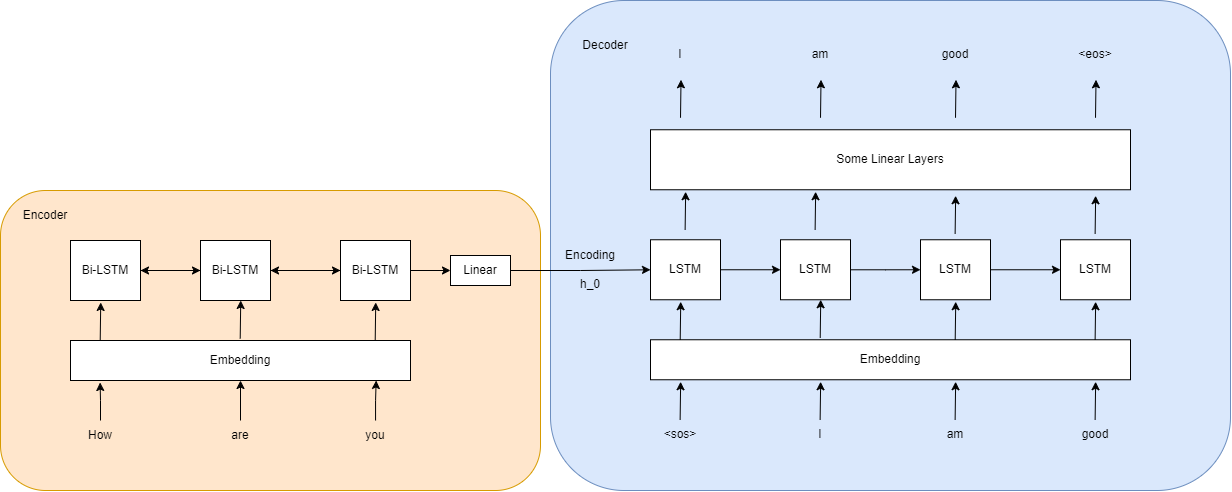

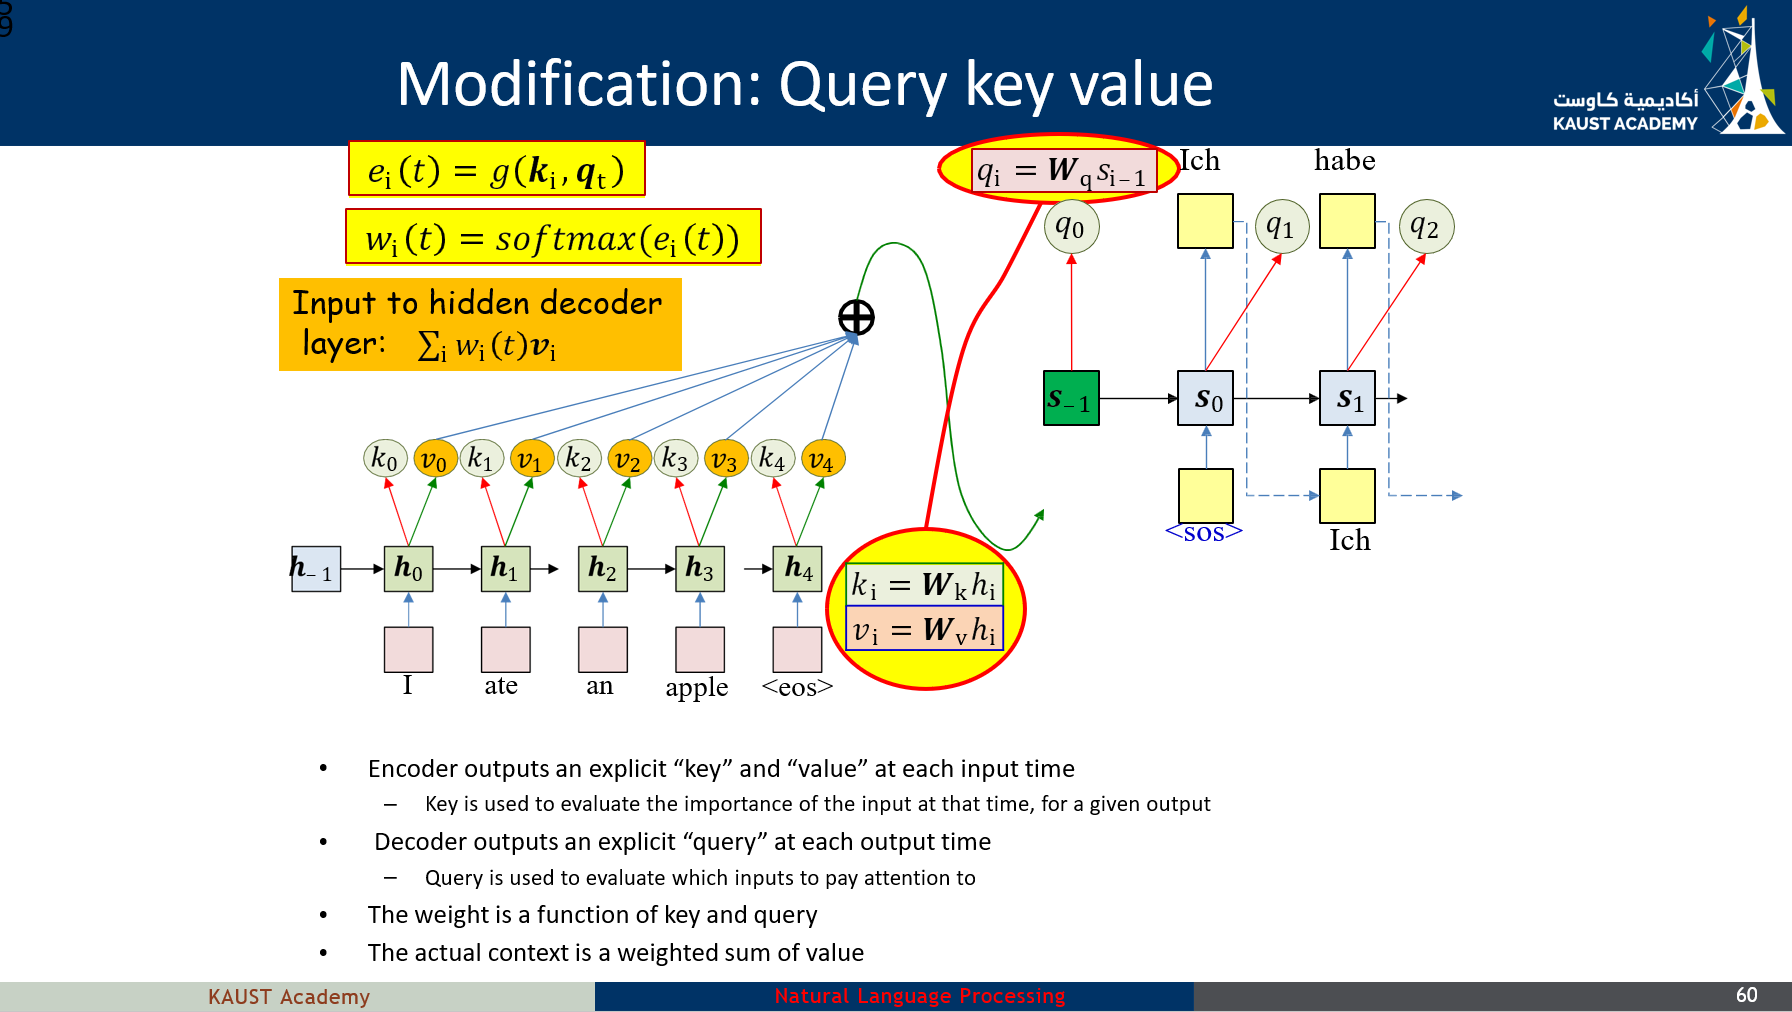

Hints:

1. Use Bi-directional LSTM in encoder.
2. Learning rate matters a lot and will need to be managed during training. Either use a learning rate schedular or optimizers with adaptive learning rate (e.g. adagrad).
3. The training and generation process will slightly differ. You need to do training using teacher forcing method.
4. Your source sentences will contain pad tokens and they will affect the encoding generated by the encoder. This is not ideal. To deal with this try using `torch.nn.utils.rnn.pack_padded_sequence` and `torch.nn.utils.rnn.pad_packed_sequence`. Study how it works and how you can use it.
5. For attention based model, you will need to write the decoder loop yourself. So, you will need to use `torch.nn.LSTMCell`.

In [ ]:
!wget https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv

--2024-07-26 23:53:57--  https://qnamakerstore.blob.core.windows.net/qnamakerdata/editorial/english/qna_chitchat_professional.tsv
Resolving qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)... 20.60.81.165
Connecting to qnamakerstore.blob.core.windows.net (qnamakerstore.blob.core.windows.net)|20.60.81.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981694 (959K) [text/plain]
Saving to: ‘qna_chitchat_professional.tsv’

qna_chitchat_profes 100%[===================>] 958.69K  --.-KB/s    in 0.1s    

2024-07-26 23:53:57 (7.49 MB/s) - ‘qna_chitchat_professional.tsv’ saved [981694/981694]



In [ ]:
import pandas as pd
pd.read_csv("qna_chitchat_professional.tsv", sep="\t")[["Question", "Answer"]].to_csv("qna_chitchat_professional.tsv", index=False, sep="\t")

In [ ]:
from IPython.display import clear_output, display
import os
import math
import random
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.datasets import CocoCaptions
import matplotlib.pyplot as plt
from tqdm import tqdm
import sentencepiece
import csv
from sklearn.model_selection import train_test_split
clear_output()


## 1-Tokenization
Tokenize the data and create a vocabulary using sentencepiece. Set vocab_size=1000, pad_id=0, unk_id=1, bos_id=2, eos_id=3. After making the tokenization model encode your data and don't forget to add <sos> and <eos>.

In [ ]:
sentencepiece.SentencePieceTrainer.train(
  input="qna_chitchat_professional.tsv",
  model_prefix="myspm_model",
  vocab_size=1000,
  pad_id=0,
  unk_id=1,
  bos_id=2,
  eos_id=3,
  pad_piece='<pad>',
  unk_piece='<unk>',
  bos_piece='<sos>',
  eos_piece='<eos>'
)

In [ ]:
spm = sentencepiece.SentencePieceProcessor(model_file="myspm_model.model")
vocab = [spm.id_to_piece(i) for i in range(spm.get_piece_size())]
print("Vocabulary sample:")
print(vocab[:10])

Vocabulary sample:
['<pad>', '<unk>', '<sos>', '<eos>', '.', '▁I', "'", '▁you', 's', '▁to']


In [ ]:
encoded_questions = []
encoded_answers = []

with open("qna_chitchat_professional.tsv", 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    next(reader)
    for row in reader:
        question = spm.encode_as_ids(row[0])
        answer = spm.encode_as_ids(row[1])
        question = [spm.bos_id()] + question + [spm.eos_id()]
        answer = [spm.bos_id()] + answer + [spm.eos_id()]
        encoded_questions.append(question)
        encoded_answers.append(answer)

print(encoded_questions[0])
print(encoded_answers[0])

[2, 40, 7, 63, 529, 12, 3]
[2, 5, 18, 6, 10, 17, 14, 290, 4, 3]


## 2-Padding
Pad your source and target data.

In [ ]:
max_q_length = max(len(q) for q in encoded_questions)
max_a_length = max(len(a) for a in encoded_answers)
questions_lengths = [len(q) for q in encoded_questions]
padded_questions = [q + [spm.pad_id()] * (max_q_length - len(q)) for q in encoded_questions]
padded_answers = [a + [spm.pad_id()] * (max_a_length - len(a)) for a in encoded_answers]
print(max_q_length, max_a_length) # reasonable lengths
print(padded_questions[0])
print(questions_lengths[0])
print(padded_answers[0])

26 46
[2, 40, 7, 63, 529, 12, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
7
[2, 5, 18, 6, 10, 17, 14, 290, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## 3-Data split
Split the data into 80:20 train and test set.


In [ ]:
questions_tensor = torch.tensor(padded_questions, dtype=torch.long)
questions_lengths_tensor = torch.tensor(questions_lengths, dtype=torch.long)
answers_tensor = torch.tensor(padded_answers, dtype=torch.long)
# print(questions_lengths_tensor)
train_val_questions, test_questions, train_val_answers, test_answers, train_val_lengths, test_lengths = train_test_split(
    questions_tensor, answers_tensor, questions_lengths_tensor, test_size=0.2
)

train_questions, val_questions, train_answers, val_answers, train_lengths, val_lengths = train_test_split(
    train_val_questions, train_val_answers, train_val_lengths, test_size=0.1
)

class CustomDataset(Dataset):

    def __init__(self, questions, lengths, answers):
        self.questions = questions
        self.lengths = lengths
        self.answers = answers

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question = self.questions[idx]
        length = self.lengths[idx]
        answer = self.answers[idx]
        return question, length, answer

train_dataset = CustomDataset(train_questions, train_lengths, train_answers)
val_dataset = CustomDataset(val_questions, val_lengths, val_answers)
test_dataset = CustomDataset(test_questions, test_lengths, test_answers)

batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
len(train_dataloader.dataset), len(val_dataloader.dataset), len(test_dataloader.dataset)

(7050, 784, 1959)

## 4-Simple LSTM based QA model
Create and train your a simple LSTM based QA model. You can follow the architecture design given below.
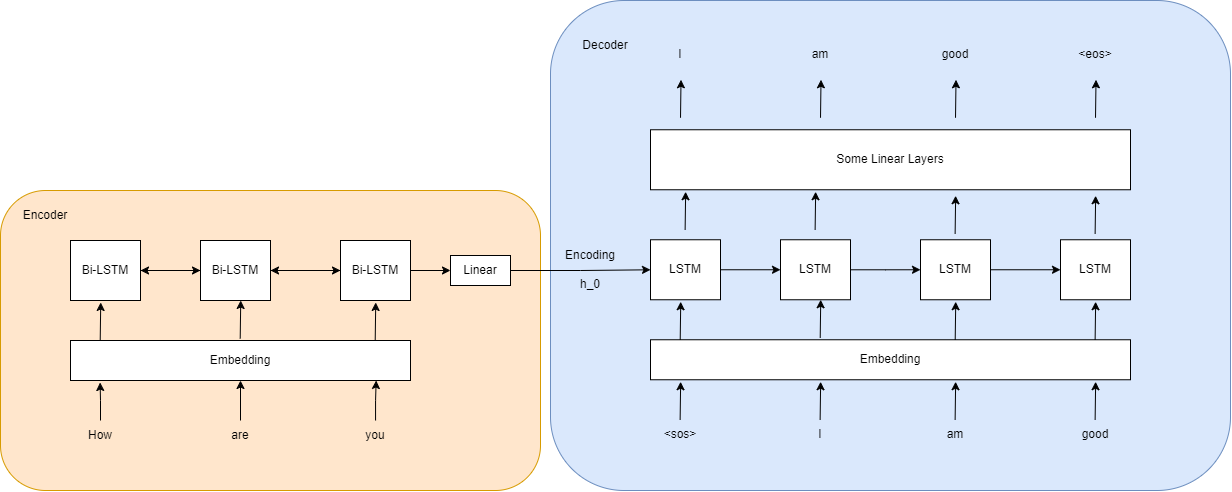


### Models

In [ ]:
class QuestionEncoder(nn.Module):

  def __init__(self, embed_size, hidden_size, num_layers, vocab_size, decoder_hidden_units):
    super(QuestionEncoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(hidden_size * 2, decoder_hidden_units)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x, lengths):
    x = self.embedding(x)
    x = self.dropout(x)
    x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True,enforce_sorted=False)
    output, (hidden, cell) = self.lstm(x)
    output, output_lengths = nn.utils.rnn.pad_packed_sequence(output, batch_first=True) # TODO check why
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
    hidden = self.fc(hidden)
    return hidden

class AnswerDecoder(nn.Module):
  def __init__(self, embed_size, hidden_size, num_layers, vocab_size):
    super(AnswerDecoder, self).__init__()
    self.num_layers = num_layers
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, vocab_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x, hidden, cell=None, unsqueezed=False):
    x = self.embedding(x)
    x = self.dropout(x)
    if cell is None:
      cell = torch.zeros_like(hidden).to(hidden.device)
    if not unsqueezed:
      hidden = hidden.unsqueeze(0)
      cell = cell.unsqueeze(0)
    output, (hidden, cell) = self.lstm(x, (hidden, cell))
    output = self.fc(output)
    return output, hidden, cell

class QuestionAnswerModel(nn.Module):
  def __init__(self, embed_size, num_layers, vocab_size, encoder_hidden_units, decoder_hidden_units):
    super(QuestionAnswerModel, self).__init__()
    self.encoder = QuestionEncoder(embed_size, encoder_hidden_units, num_layers, vocab_size, decoder_hidden_units)
    self.decoder = AnswerDecoder(embed_size, decoder_hidden_units, num_layers, vocab_size)

    self.num_layers = num_layers
    self.decoder_hidden_units = decoder_hidden_units

  def forward(self, question, answer, question_length):
    hidden = self.encoder(question, question_length)
    output, _, _ = self.decoder(answer, hidden)
    return output

  def answer_question(self, question):
    with torch.no_grad():
      question = question.unsqueeze(0)
      question_length = torch.tensor([question.size(1)])
      hidden = self.encoder(question, question_length)
      hidden = hidden.view(self.num_layers, 1, self.decoder_hidden_units)
      # start_token = torch.tensor([[spm.bos_id()]], dtype=torch.long, device=question.device)
      generated_answer = [spm.bos_id()]
      inputs = torch.tensor([generated_answer], dtype=torch.long, device=question.device)
      outputs, hidden, cell = self.decoder(inputs, hidden, unsqueezed = True)
      for _ in range(40):
          inputs = torch.tensor([generated_answer], dtype=torch.long, device=question.device)
          outputs, hidden, cell = self.decoder(inputs, hidden, cell, unsqueezed = True)
          predicted = outputs[:, -1, :].argmax(dim=-1)
          predicted_token = predicted.item()
          generated_answer.append(predicted_token)
          if predicted_token == spm.eos_id():
              break
      generated_answer = generated_answer[1:-1]
      generated_answer = spm.decode(generated_answer)
      return generated_answer




In [ ]:
embed_size = 256
encoder_hidden_units = 256
decoder_hidden_units = 256
encoder_num_layers = 1
decoder_num_layers = 1
vocab_size = len(vocab)
num_decoder_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
batch = next(iter(train_dataloader))
questions, questions_lengths, answers = batch

## sanity check
encoder = QuestionEncoder(embed_size, encoder_hidden_units, encoder_num_layers, vocab_size, decoder_hidden_units)
decoder = AnswerDecoder(embed_size, decoder_hidden_units, decoder_num_layers, vocab_size)
encoder = encoder.to(device)
decoder = decoder.to(device)
print("questions shape: ", questions.shape)
features = encoder(questions.to(device), questions_lengths)
outputs, _, _ = decoder(answers.to(device), features)
print(f"Features shape: {features.unsqueeze(0).shape}")
print(f"Outputs shape: {outputs.shape}")
question_answer_model = QuestionAnswerModel(embed_size, encoder_num_layers, vocab_size, encoder_hidden_units, decoder_hidden_units)
question_answer_model = question_answer_model.to(device)
full_model_outputs = question_answer_model(questions.to(device), answers.to(device), questions_lengths)
print(f"Full model outputs shape: {full_model_outputs.shape}")


questions shape:  torch.Size([128, 26])
Features shape: torch.Size([1, 128, 256])
Outputs shape: torch.Size([128, 46, 1000])
Full model outputs shape: torch.Size([128, 46, 1000])


In [ ]:
test_questions = [
    "Can you breathe?",
    "Who wrote Romeo and Juliet?",
    "What is the largest planet in our solar system?",
    "Can you ask me why I'm here??"
]
question_answer_model.eval()
for question in test_questions:
    question_tokens = spm.encode_as_ids(question)
    question_tensor = torch.tensor(question_tokens, dtype=torch.long)
    generated_answer = question_answer_model.answer_question(question_tensor.to(device))
    print("Question:", question)
    print("Generated Answer:", generated_answer)
    print()

Question: Can you breathe?
Generated Answer: intelligentoodood Do Nice dumb dumb on Life vegetable cleverichother tow people sex managerpressrgergeeinterestinginteresting likable No Wonsol usual catally dream seeminterestinginteresting travel an wintop cream

Question: Who wrote Romeo and Juliet?
Generated Answer: intelligentoodood Do Nice dumb dumb on Life vegetable cleverichother tow people sex managerpressrgergeeinterestinginteresting likable No Wonsol usual catally dream seeminterestinginteresting travel an wintop cream

Question: What is the largest planet in our solar system?
Generated Answer: intelligentoodood Do Nice dumb dumb on Life vegetable cleverichother tow people sex managerpressrgergeeinterestinginteresting likable No Wonsol usual catally dream seeminterestinginteresting travel an wintop cream

Question: Can you ask me why I'm here??
Generated Answer: intelligentoodood Do Nice dumb dumb on Life vegetable cleverichother tow people sex managerpressrgergeeinterestingintere

### Training loop

In [ ]:
learning_rate = 1e-3
num_epochs = 100
optimizer = torch.optim.Adam(question_answer_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=spm.bos_id())
# TODO lr schedular
lr_schedular = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    question_answer_model.train()
    running_loss = 0

    for idx, (questions, questions_lengths, answers) in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader), leave=False
    ):
        questions = questions.to(device)
        questions_lengths = questions_lengths
        answers = answers.to(device)
        outputs = question_answer_model(questions.to(device), answers[:, :-1].to(device), questions_lengths)
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # lr_schedular.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    # Validation loop
    question_answer_model.eval()
    val_running_loss = 0

    with torch.no_grad():
        for questions, questions_lengths, answers in tqdm(val_dataloader, leave=False):
            questions = questions.to(device)
            questions_lengths = questions_lengths
            answers = answers.to(device)

            outputs = question_answer_model(questions, answers[:, :-1], questions_lengths)
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1)
            )
            val_running_loss += loss.item()

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_epoch_loss)
    # Print training and validation losses
    print(f"\nEpoch: {epoch+1}/{num_epochs} Training loss: {epoch_loss} \t Validation loss: {val_epoch_loss}")



Epoch: 1/100 Training loss: 1.6638084234935897 	 Validation loss: 0.7468884587287903



Epoch: 2/100 Training loss: 0.5820535852440766 	 Validation loss: 0.348012170621327



Epoch: 3/100 Training loss: 0.304649343714118 	 Validation loss: 0.18749321358544485



Epoch: 4/100 Training loss: 0.19247882493904658 	 Validation loss: 0.13403107013021195



Epoch: 5/100 Training loss: 0.1454815896494048 	 Validation loss: 0.11105660668441228



Epoch: 6/100 Training loss: 0.1217708136620266 	 Validation loss: 0.09954553523233958



Epoch: 7/100 Training loss: 0.10883101341979844 	 Validation loss: 0.09186556403126035



Epoch: 8/100 Training loss: 0.09931979408221585 	 Validation loss: 0.0848265779869897



Epoch: 9/100 Training loss: 0.09134367108345032 	 Validation loss: 0.08023040209497724



Epoch: 10/100 Training loss: 0.08413414018494743 	 Validation loss: 0.07265908377511161



Epoch: 11/100 Training loss: 0.07767418452671596 	 Validation loss: 0.06779724040201732



Epoch: 12/100 Training loss: 0.07144670827048165 	 Validation loss: 0.062091797058071406



Epoch: 13/100 Training loss: 0.06699671543070249 	 Validation loss: 0.05879731635962214



Epoch: 14/100 Training loss: 0.06286029477736779 	 Validation loss: 0.05607964790293148



Epoch: 15/100 Training loss: 0.05869728486452784 	 Validation loss: 0.054495097271033695



Epoch: 16/100 Training loss: 0.05546446916248117 	 Validation loss: 0.04983300556029592



Epoch: 17/100 Training loss: 0.05196794568161879 	 Validation loss: 0.048205625265836716



Epoch: 18/100 Training loss: 0.048251059904162376 	 Validation loss: 0.04517956503799984



Epoch: 19/100 Training loss: 0.04583661304786801 	 Validation loss: 0.044603402593306134



Epoch: 20/100 Training loss: 0.043177540081420114 	 Validation loss: 0.04217929446271488



Epoch: 21/100 Training loss: 0.0402897970883974 	 Validation loss: 0.039305933352027624



Epoch: 22/100 Training loss: 0.03687983066109674 	 Validation loss: 0.03740469552576542



Epoch: 23/100 Training loss: 0.03473585268615612 	 Validation loss: 0.03514550892370088



Epoch: 24/100 Training loss: 0.032200198088373454 	 Validation loss: 0.033658258350832124



Epoch: 25/100 Training loss: 0.029862572605322515 	 Validation loss: 0.032004745943205695



Epoch: 26/100 Training loss: 0.027793787303380668 	 Validation loss: 0.0294272636196443



Epoch: 27/100 Training loss: 0.025518693528803333 	 Validation loss: 0.028133087924548557



Epoch: 28/100 Training loss: 0.024290594704715267 	 Validation loss: 0.027785401791334152



Epoch: 29/100 Training loss: 0.022560003779030273 	 Validation loss: 0.026489622092672756



Epoch: 30/100 Training loss: 0.021243771970538155 	 Validation loss: 0.025306970945426395



Epoch: 31/100 Training loss: 0.019567469251342118 	 Validation loss: 0.02425097780568259



Epoch: 32/100 Training loss: 0.01817681991295623 	 Validation loss: 0.023440288645880564



Epoch: 33/100 Training loss: 0.016876477033032904 	 Validation loss: 0.02264589044664587



Epoch: 34/100 Training loss: 0.015202307375147939 	 Validation loss: 0.02228632795491389



Epoch: 35/100 Training loss: 0.014584198826923966 	 Validation loss: 0.021922844728188857



Epoch: 36/100 Training loss: 0.013625034434621089 	 Validation loss: 0.021157434875411645



Epoch: 37/100 Training loss: 0.012299656202750546 	 Validation loss: 0.02182593648987157



Epoch: 38/100 Training loss: 0.012136321365168052 	 Validation loss: 0.021308212407997677



Epoch: 39/100 Training loss: 0.011319578334223479 	 Validation loss: 0.020127482579222748



Epoch: 40/100 Training loss: 0.010742752846064312 	 Validation loss: 0.020884903680000986



Epoch: 41/100 Training loss: 0.010442776331079326 	 Validation loss: 0.020628216277275766



Epoch: 42/100 Training loss: 0.009857969333617283 	 Validation loss: 0.020540419167705944



Epoch: 43/100 Training loss: 0.008936145841809255 	 Validation loss: 0.020189539795475348



Epoch: 44/100 Training loss: 0.008389877995276558 	 Validation loss: 0.02057023173464196



Epoch: 45/100 Training loss: 0.00863706148395847 	 Validation loss: 0.02022585898105587



Epoch: 46/100 Training loss: 0.007818361860699952 	 Validation loss: 0.019761139526963234



Epoch: 47/100 Training loss: 0.007709003219913159 	 Validation loss: 0.01949095632880926



Epoch: 48/100 Training loss: 0.006795505955649007 	 Validation loss: 0.01939561404287815



Epoch: 49/100 Training loss: 0.006220392766408622 	 Validation loss: 0.01948600648237126



Epoch: 50/100 Training loss: 0.006182113392112244 	 Validation loss: 0.019132575818470547



Epoch: 51/100 Training loss: 0.005592118279309943 	 Validation loss: 0.019332069105335643



Epoch: 52/100 Training loss: 0.005553378241269716 	 Validation loss: 0.01944491919130087



Epoch: 53/100 Training loss: 0.005901525362527796 	 Validation loss: 0.019693677446671894



Epoch: 54/100 Training loss: 0.005691680113419092 	 Validation loss: 0.019932634197175503



Epoch: 55/100 Training loss: 0.005002643547153899 	 Validation loss: 0.019338011741638184



Epoch: 56/100 Training loss: 0.005034733800649909 	 Validation loss: 0.02030396195394652



Epoch: 57/100 Training loss: 0.004712466233676034 	 Validation loss: 0.020735562779009342



Epoch: 58/100 Training loss: 0.004408967506606132 	 Validation loss: 0.01946748194417783



Epoch: 59/100 Training loss: 0.004318228457123041 	 Validation loss: 0.020070141181349754



Epoch: 60/100 Training loss: 0.00390214377382238 	 Validation loss: 0.019606292646910464



Epoch: 61/100 Training loss: 0.003857807437140894 	 Validation loss: 0.020166719864521707



Epoch: 62/100 Training loss: 0.00398967183926808 	 Validation loss: 0.02008410157369716



Epoch: 63/100 Training loss: 0.004092919665189194 	 Validation loss: 0.020461624754326686



Epoch: 64/100 Training loss: 0.003636152945026489 	 Validation loss: 0.02018154226243496



Epoch: 65/100 Training loss: 0.0035150291161179276 	 Validation loss: 0.020426695767257894



Epoch: 66/100 Training loss: 0.0038031750570683342 	 Validation loss: 0.020021364891103337



Epoch: 67/100 Training loss: 0.0036319029064283575 	 Validation loss: 0.01981001440435648



Epoch: 68/100 Training loss: 0.003247658285545185 	 Validation loss: 0.019340228954596177



Epoch: 69/100 Training loss: 0.003137997020011036 	 Validation loss: 0.021485909021326473



Epoch: 70/100 Training loss: 0.0030836155638098717 	 Validation loss: 0.019737984852067063



Epoch: 71/100 Training loss: 0.003029344611734684 	 Validation loss: 0.020097487872200354



Epoch: 72/100 Training loss: 0.003066177664939979 	 Validation loss: 0.018724799821419374



Epoch: 73/100 Training loss: 0.0029392582884091617 	 Validation loss: 0.02002381919217961



Epoch: 74/100 Training loss: 0.00275631678856111 	 Validation loss: 0.020231243489044055



Epoch: 75/100 Training loss: 0.002753999352405247 	 Validation loss: 0.0202100934194667



Epoch: 76/100 Training loss: 0.0025322171568404883 	 Validation loss: 0.019683208050472394



Epoch: 77/100 Training loss: 0.0023987900681926738 	 Validation loss: 0.01994664621140276



Epoch: 78/100 Training loss: 0.002457783146383008 	 Validation loss: 0.018829149327107837



Epoch: 79/100 Training loss: 0.002281801132734732 	 Validation loss: 0.019410700803356513



Epoch: 80/100 Training loss: 0.002515808415150137 	 Validation loss: 0.019757647200354507



Epoch: 81/100 Training loss: 0.002264770440108675 	 Validation loss: 0.0195484422147274



Epoch: 82/100 Training loss: 0.002182783948748173 	 Validation loss: 0.020001085874225413



Epoch: 83/100 Training loss: 0.0019816233533284894 	 Validation loss: 0.020349764531212195



Epoch: 84/100 Training loss: 0.002162787749382135 	 Validation loss: 0.01940401058111872



Epoch: 85/100 Training loss: 0.0019285239665935347 	 Validation loss: 0.021113170044762746



Epoch: 86/100 Training loss: 0.0020298984361163874 	 Validation loss: 0.0201322611953531



Epoch: 87/100 Training loss: 0.002223821342860382 	 Validation loss: 0.020341722826872553



Epoch: 88/100 Training loss: 0.0017296237409547238 	 Validation loss: 0.020752908129777228



Epoch: 89/100 Training loss: 0.0017573203310478544 	 Validation loss: 0.020152955715145384



Epoch: 90/100 Training loss: 0.002075364435638351 	 Validation loss: 0.020799852907657623



Epoch: 91/100 Training loss: 0.001702796968207362 	 Validation loss: 0.02061626687645912



Epoch: 92/100 Training loss: 0.002366210739377753 	 Validation loss: 0.02089135056095464



Epoch: 93/100 Training loss: 0.0048840006389322555 	 Validation loss: 0.020748812040047988



Epoch: 94/100 Training loss: 0.0026890185150218065 	 Validation loss: 0.019352028811616555



Epoch: 95/100 Training loss: 0.002406817118753679 	 Validation loss: 0.019183333297925338



Epoch: 96/100 Training loss: 0.0023933029983059634 	 Validation loss: 0.019193536202822412



Epoch: 97/100 Training loss: 0.002109452909540518 	 Validation loss: 0.02050416756953512



Epoch: 98/100 Training loss: 0.002875249577170637 	 Validation loss: 0.02113290157701288



Epoch: 99/100 Training loss: 0.002124224034300174 	 Validation loss: 0.021833064566765512



Epoch: 100/100 Training loss: 0.0018871145616036042 	 Validation loss: 0.020193429397685186


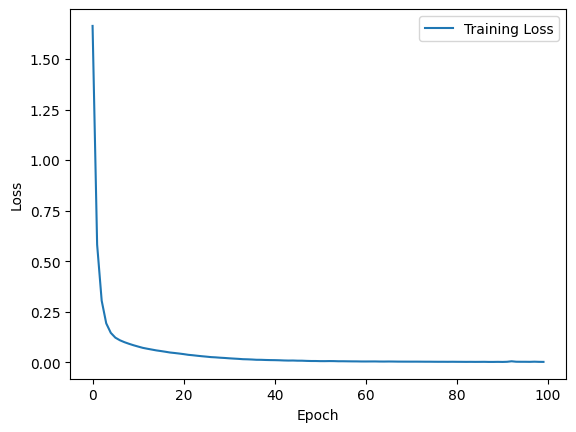

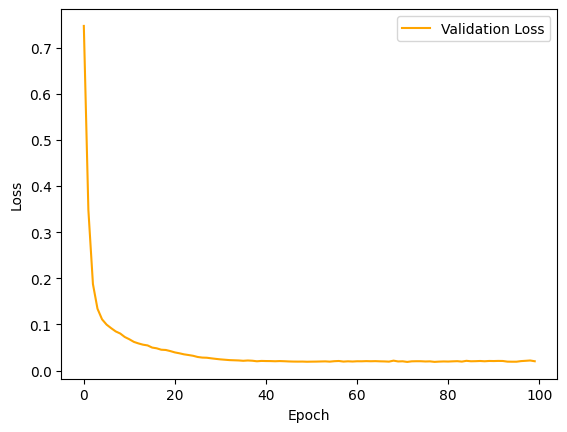

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='Validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### samples

In [ ]:
test_questions = [
    "Can you breathe?",
    "Who wrote Romeo and Juliet?",
    "What is the largest planet in our solar system?",
    "Can you ask me why I'm here?",
    "Have you ever been in love?",
    "What is my purpose in life?"
]
question_answer_model.eval()
for question in test_questions:
    question_tokens = spm.encode_as_ids(question)
    question_tensor = torch.tensor(question_tokens, dtype=torch.long)
    generated_answer = question_answer_model.answer_question(question_tensor.to(device))
    print("Question:", question)
    print("Generated Answer:", generated_answer)
    print()

Question: Can you breathe?
Generated Answer: That's not something I can do.

Question: Who wrote Romeo and Juliet?
Generated Answer: I'm here to answer your questions and help out.

Question: What is the largest planet in our solar system?
Generated Answer: I don't have any jokes lined up.

Question: Can you ask me why I'm here?
Generated Answer: I'm very sorry to hear that.

Question: Have you ever been in love?
Generated Answer: Great.

Question: What is my purpose in life?
Generated Answer: I don't have any jokes lined up.



## 5-Model with Attention
Create and train an attention based LSTM QA model. Follow the design covered in the lecture. See fig. 2 below.

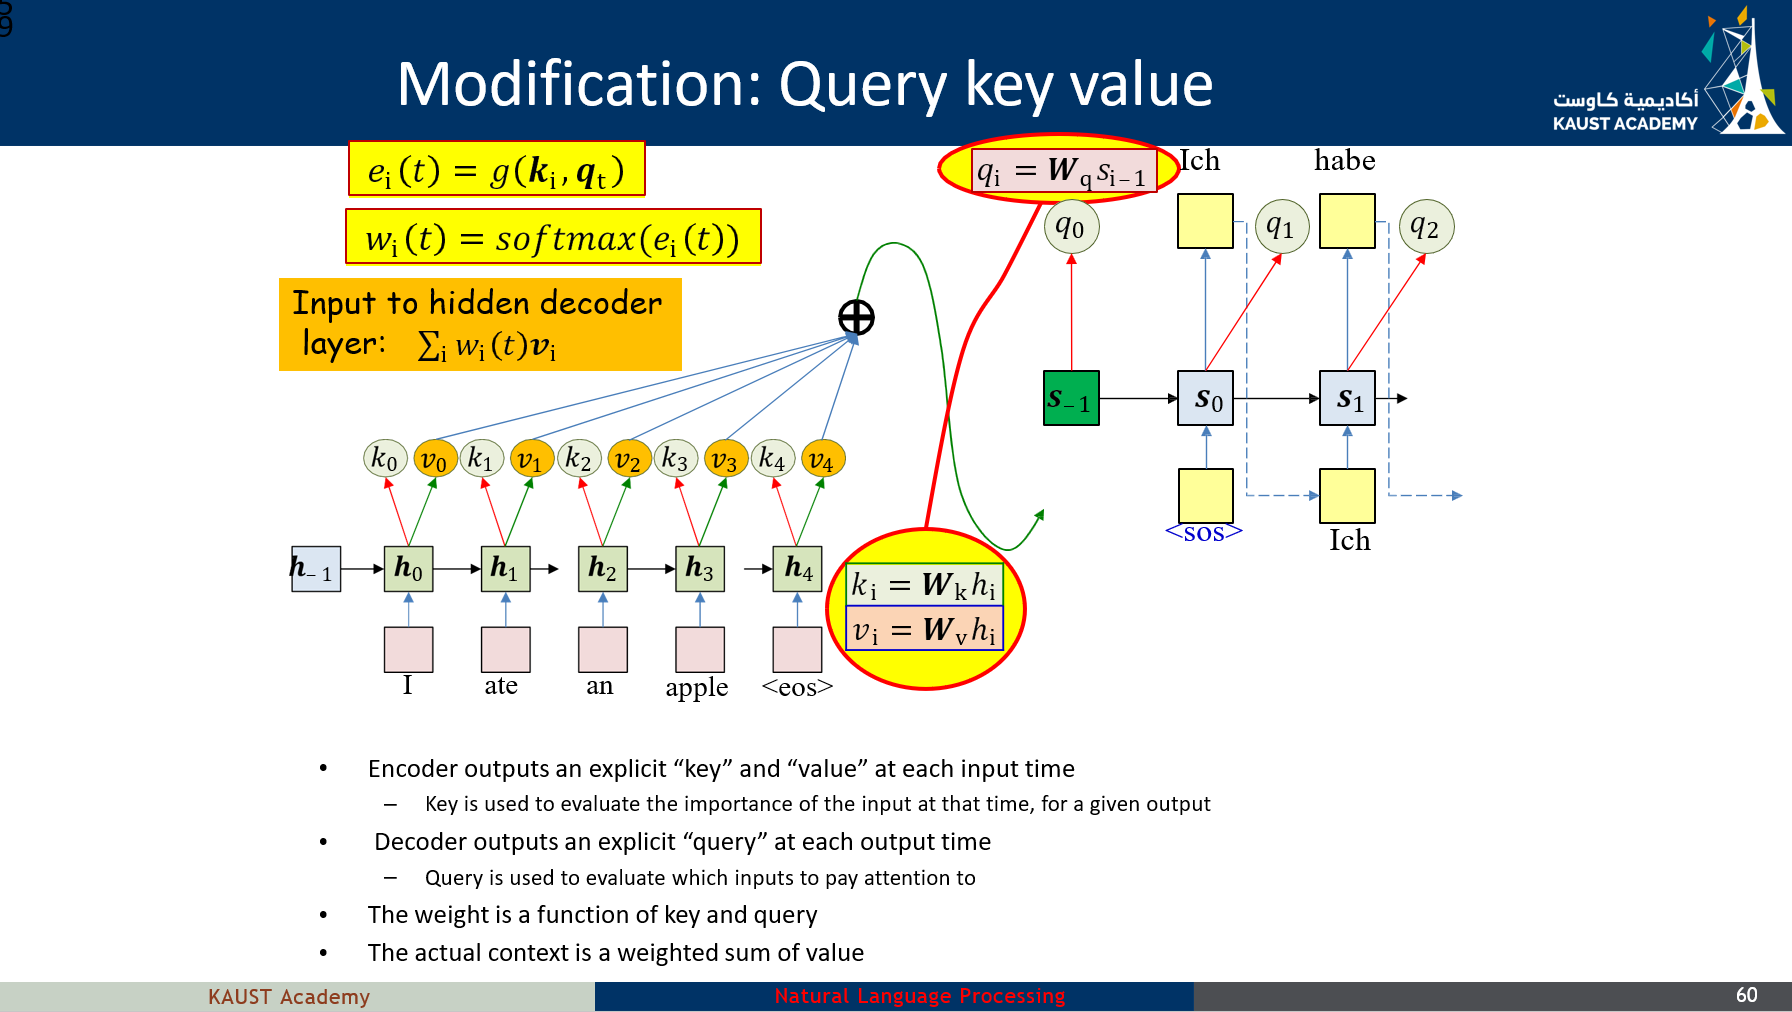

### Models

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, attention_dim):
        super(Attention, self).__init__()
        self.k = nn.Linear(encoder_hidden_size * 2, attention_dim)
        self.v = nn.Linear(encoder_hidden_size * 2, attention_dim)
        self.q = nn.Linear(decoder_hidden_size, attention_dim)
        self.attention_dim = attention_dim

    def forward(self, q, encoder_outputs):
        batch_size, seq_len, _ = encoder_outputs.size()
        # print("Before K and V")
        # print("encoder outputs shape: HERE ", encoder_outputs.shape)
        K = self.k(encoder_outputs.view(-1, encoder_outputs.size(2)))
        K = K.view(batch_size, seq_len, -1)

        V = self.v(encoder_outputs.view(-1, encoder_outputs.size(2)))
        V = V.view(batch_size, seq_len, -1)
        Q = self.q(q)
        if (len(Q.shape) < 3):
          Q = Q.unsqueeze(1)
        # print("shape of Q", Q.shape)
        # print("shape of K", K.shape)

        scores = torch.bmm(Q, K.transpose(1, 2)).squeeze(1)
        # print(f"scores are of shape: {scores.shape}")
        attn_weights = F.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), V).squeeze(1)

        return context, attn_weights

class QuestionEncoderWithAttention(nn.Module):
  def __init__(self, embed_size, hidden_size, num_layers, vocab_size):
    super(QuestionEncoderWithAttention, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
    self.fc = nn.Linear(hidden_size * 2, hidden_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, x, lengths):
    x = self.embedding(x)
    x = self.dropout(x)
    x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
    outputs, (hidden, cell) = self.lstm(x)
    outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
    hidden = self.fc(hidden)
    return outputs, hidden

class AnswerDecoderWithAttention(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, vocab_size, encoder_hidden_size, attention_dim):
        super(AnswerDecoderWithAttention, self).__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm_cell = nn.LSTMCell(embed_size + attention_dim, hidden_size, bias=True)

        self.init_h = nn.Linear(encoder_hidden_size, hidden_size)
        self.init_c = nn.Linear(encoder_hidden_size, hidden_size)
        self.f_beta = nn.Linear(hidden_size, encoder_hidden_size)
        self.sigmoid = nn.Sigmoid()

        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
        self.vocab_size = vocab_size

        self.attention = Attention(encoder_hidden_size, hidden_size, attention_dim)

    def forward(self, x, hidden, encoder_outputs, cell=None, unsqueezed=False):
        batch_size = x.size(0)
        seq_length = x.size(1)

        if cell is None:
            cell = torch.zeros_like(hidden).to(hidden.device)
        if not unsqueezed:
            if (len(hidden.shape) < 3):
              # print("hidden shape before ", hidden.shape)
              hidden = hidden.unsqueeze(0)
              cell = cell.unsqueeze(0)

            # hidden = hidden.unsqueeze(0)
            # cell = cell.unsqueeze(0)

        outputs = torch.zeros(batch_size, seq_length, self.vocab_size).to(x.device)

        for t in range(seq_length):
            input_t = x[:, t].unsqueeze(1)
            embedded = self.embedding(input_t).squeeze(1)
            embedded = self.dropout(embedded)

            # Debug print statement for embedded input
            # print(f"Embedded input shape (t={t}): {embedded.shape}")
            # print(f"hidden and encoder outputs passed to attention", hidden.shape, encoder_outputs.shape)
            context, attention_weights = self.attention(hidden.squeeze(0), encoder_outputs)

            lstm_input = torch.cat((embedded, context), dim=1)
            # print(f"LSTM input shape (t={t}): {lstm_input.shape}")
            # print(f"hidden shape", hidden.shape)
            hidden, cell = self.lstm_cell(lstm_input, (hidden.squeeze(0), cell.squeeze(0)))

            if (len(hidden.shape) < 3):
              # print("hidden shape before ", hidden.shape)
              hidden = hidden.unsqueeze(0)
              cell = cell.unsqueeze(0)
              # print("After ", hidden.shape)

            output = self.fc(hidden.squeeze(0))
            outputs[:, t] = output

        return outputs, hidden, cell

class QuestionAnswerModelWithAttention(nn.Module):
    def __init__(self, embed_size, encoder_hidden_size, decoder_hidden_size, num_layers, vocab_size, attention_dim):
        super(QuestionAnswerModelWithAttention, self).__init__()
        self.encoder = QuestionEncoderWithAttention(embed_size, encoder_hidden_size, num_layers, vocab_size)
        self.decoder = AnswerDecoderWithAttention(embed_size, decoder_hidden_size, num_layers, vocab_size, encoder_hidden_size, attention_dim)

        self.num_layers = num_layers
        self.decoder_hidden_size = decoder_hidden_size

    def forward(self, question, answer, question_length):
        encoder_outputs, hidden = self.encoder(question, question_length)
        output, _, _ = self.decoder(answer, hidden, encoder_outputs)
        return output

    def answer_question(self, question, max_length=40):
        with torch.no_grad():
            question = question.unsqueeze(0)
            question_length = torch.tensor([question.size(1)])
            encoder_outputs, hidden = self.encoder(question, question_length)

            generated_answer = [spm.bos_id()]
            inputs = torch.tensor([generated_answer], dtype=torch.long, device=question.device)

            for _ in range(max_length):
                outputs, hidden, cell = self.decoder(inputs, hidden, encoder_outputs)
                predicted = outputs[:, -1, :].argmax(dim=-1)
                predicted_token = predicted.item()
                generated_answer.append(predicted_token)

                if predicted_token == spm.eos_id():
                    break

                inputs = torch.tensor([[predicted_token]], dtype=torch.long, device=question.device)

            generated_answer = generated_answer[1:-1]
            generated_answer = spm.decode(generated_answer)
            return generated_answer


In [ ]:
embed_size = 256
encoder_hidden_units = 512
decoder_hidden_units = 512
encoder_num_layers = 1
decoder_num_layers = 1
vocab_size = len(vocab)
num_decoder_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
attention_dim = 256

In [ ]:
batch = next(iter(train_dataloader))
questions, questions_lengths, answers = batch

In [ ]:

encoder = QuestionEncoderWithAttention(embed_size, encoder_hidden_units, encoder_num_layers, vocab_size)
decoder = AnswerDecoderWithAttention(embed_size, decoder_hidden_units, decoder_num_layers, vocab_size, encoder_hidden_units, attention_dim)
encoder = encoder.to(device)
decoder = decoder.to(device)
print("questions shape: ", questions.shape)
outputs, features = encoder(questions.to(device), questions_lengths)
print(f"Features shape: {features.shape}")
print(f"encoder outputs shape: {outputs.shape}")
outputs, _, _ = decoder(answers.to(device), features, outputs)

# print(f"Outputs shape: {outputs.shape}")
question_answer_model_with_attention = QuestionAnswerModelWithAttention(embed_size, encoder_hidden_units, decoder_hidden_units,  encoder_num_layers, vocab_size, attention_dim)
question_answer_model_with_attention = question_answer_model_with_attention.to(device)
full_model_outputs = question_answer_model_with_attention(questions.to(device), answers.to(device), questions_lengths)
print(f"Full model outputs shape: {full_model_outputs.shape}")


questions shape:  torch.Size([128, 26])
Features shape: torch.Size([128, 512])
encoder outputs shape: torch.Size([128, 16, 1024])
Full model outputs shape: torch.Size([128, 46, 1000])


In [ ]:
test_questions = [
    "Can you breathe?",
    "Who wrote Romeo and Juliet?",
    "What is the largest planet in our solar system?",
    "Can you ask me why I'm here?",
    "Have you ever been in love?",
    "What is my purpose in life?"
]
question_answer_model_with_attention.eval()
for question in test_questions:
    question_tokens = spm.encode_as_ids(question)
    question_tensor = torch.tensor(question_tokens, dtype=torch.long)
    generated_answer = question_answer_model_with_attention.answer_question(question_tensor.to(device))
    print("Question:", question)
    print("Generated Answer:", generated_answer)
    print()

Question: Can you breathe?
Generated Answer: horse evening guy trip your work girl cuter p ho somebody other Christ am word guy trip your work girl cuter p ho somebody other Christ am word guy trip your work girl cuter p ho somebody other Christ

Question: Who wrote Romeo and Juliet?
Generated Answer: Ve robot purpose directorinteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel

Question: What is the largest planet in our solar system?
Generated Answer: idiotant understand technology thank ha homeunch see cuter p ho assumspecial auntie Assistant again expect bredi could best technology again expect bredi could best technology again expect bredi could best technology again expect

Question: Can you ask me why I'm here?
Generated Answer: Ve robot purpose directorinteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel Dainteresting feel D

### Training loop

In [ ]:
learning_rate = 1e-3
num_epochs = 100
optimizer = torch.optim.Adam(question_answer_model_with_attention.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=spm.bos_id())
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-9)

In [ ]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    question_answer_model_with_attention.train()
    running_loss = 0

    for idx, (questions, questions_lengths, answers) in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader), leave=False
    ):
        questions = questions.to(device)
        questions_lengths = questions_lengths
        answers = answers.to(device)
        outputs = question_answer_model_with_attention(questions.to(device), answers[:, :-1].to(device), questions_lengths)
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    lr_schedular.step()
    # Validation loop
    question_answer_model_with_attention.eval()
    val_running_loss = 0

    with torch.no_grad():
        for questions, questions_lengths, answers in tqdm(val_dataloader, leave=False):
            questions = questions.to(device)
            questions_lengths = questions_lengths
            answers = answers.to(device)

            outputs = question_answer_model_with_attention(questions, answers[:, :-1], questions_lengths)
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), answers[:, 1:].reshape(-1)
            )
            val_running_loss += loss.item()

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_losses.append(val_epoch_loss)
    print(f"\nEpoch: {epoch+1}/{num_epochs} Training loss: {epoch_loss} \t Validation loss: {val_epoch_loss}")



Epoch: 1/100 Training loss: 1.3235069098217147 	 Validation loss: 0.6639580130577087



Epoch: 2/100 Training loss: 0.4344755243510008 	 Validation loss: 0.20873177690165384



Epoch: 3/100 Training loss: 0.18145730293222836 	 Validation loss: 0.1205248311161995



Epoch: 4/100 Training loss: 0.12414678359138114 	 Validation loss: 0.09676352036850792



Epoch: 5/100 Training loss: 0.1014031306175249 	 Validation loss: 0.08258150624377388



Epoch: 6/100 Training loss: 0.08450193876134497 	 Validation loss: 0.06553240546158381



Epoch: 7/100 Training loss: 0.06897856614419393 	 Validation loss: 0.05320544221571514



Epoch: 8/100 Training loss: 0.0582650494761765 	 Validation loss: 0.04681473118918283



Epoch: 9/100 Training loss: 0.04955675446295312 	 Validation loss: 0.03967551434678691



Epoch: 10/100 Training loss: 0.04200644165809665 	 Validation loss: 0.03334556653031281



Epoch: 11/100 Training loss: 0.035416046024433205 	 Validation loss: 0.028709010354110172



Epoch: 12/100 Training loss: 0.030450803394030248 	 Validation loss: 0.024951075070670674



Epoch: 13/100 Training loss: 0.024896347828741585 	 Validation loss: 0.02152490190097264



Epoch: 14/100 Training loss: 0.020355624678943838 	 Validation loss: 0.01998242044023105



Epoch: 15/100 Training loss: 0.017453180310050293 	 Validation loss: 0.019726020550089225



Epoch: 16/100 Training loss: 0.015971672421853458 	 Validation loss: 0.01724948308297566



Epoch: 17/100 Training loss: 0.012150761554948986 	 Validation loss: 0.017868156278772012



Epoch: 18/100 Training loss: 0.010587808243664247 	 Validation loss: 0.016229715597416674



Epoch: 19/100 Training loss: 0.009042908437550068 	 Validation loss: 0.01687020329492433



Epoch: 20/100 Training loss: 0.008167064320462356 	 Validation loss: 0.014260807274175542



Epoch: 21/100 Training loss: 0.0068588993744924664 	 Validation loss: 0.014120501200003284



Epoch: 22/100 Training loss: 0.006206449196075222 	 Validation loss: 0.014378619446818317



Epoch: 23/100 Training loss: 0.00510792901539909 	 Validation loss: 0.015343035970415388



Epoch: 24/100 Training loss: 0.004650875027956707 	 Validation loss: 0.014382088290793555



Epoch: 25/100 Training loss: 0.004071115628383788 	 Validation loss: 0.01454755780287087



Epoch: 26/100 Training loss: 0.004428264025981272 	 Validation loss: 0.015554965606757573



Epoch: 27/100 Training loss: 0.003966337845278238 	 Validation loss: 0.013892000674137048



Epoch: 28/100 Training loss: 0.0031038149338980603 	 Validation loss: 0.014072761072644166



Epoch: 29/100 Training loss: 0.00268489197540995 	 Validation loss: 0.014365003178162234



Epoch: 30/100 Training loss: 0.002423165989707091 	 Validation loss: 0.014234226263527359



Epoch: 31/100 Training loss: 0.0021030808316676746 	 Validation loss: 0.015287698246538639



Epoch: 32/100 Training loss: 0.001813932250765252 	 Validation loss: 0.015589377443705286



Epoch: 33/100 Training loss: 0.0015986422409436532 	 Validation loss: 0.015465102291532926



Epoch: 34/100 Training loss: 0.0016009399488601567 	 Validation loss: 0.016351808793842793



Epoch: 35/100 Training loss: 0.0014740809856448323 	 Validation loss: 0.016358100143926486



Epoch: 36/100 Training loss: 0.0014925648595505794 	 Validation loss: 0.016058764287403653



Epoch: 37/100 Training loss: 0.0014844387104468687 	 Validation loss: 0.016403498660240854



Epoch: 38/100 Training loss: 0.0016810893679835967 	 Validation loss: 0.016427083739212582



Epoch: 39/100 Training loss: 0.0013896153645224071 	 Validation loss: 0.015818926439221417



Epoch: 40/100 Training loss: 0.00133397650643019 	 Validation loss: 0.015454106032848358



Epoch: 41/100 Training loss: 0.0012205039394237766 	 Validation loss: 0.014659381804189511



Epoch: 42/100 Training loss: 0.0012055927665122518 	 Validation loss: 0.015269360704613584



Epoch: 43/100 Training loss: 0.0021241115568305497 	 Validation loss: 0.01628538074770144



Epoch: 44/100 Training loss: 0.0019327058689668775 	 Validation loss: 0.014920793573505111



Epoch: 45/100 Training loss: 0.001487826919141558 	 Validation loss: 0.014947462294782912



Epoch: 46/100 Training loss: 0.001410194746443137 	 Validation loss: 0.014915077215326684



Epoch: 47/100 Training loss: 0.0016589439099854125 	 Validation loss: 0.015611106995493174



Epoch: 48/100 Training loss: 0.0012221651421506457 	 Validation loss: 0.016617851464876106



Epoch: 49/100 Training loss: 0.0011714630750897673 	 Validation loss: 0.015374078847733992



Epoch: 50/100 Training loss: 0.0011773444706964906 	 Validation loss: 0.015445886113281761



Epoch: 51/100 Training loss: 0.0010535568159996597 	 Validation loss: 0.017064812194023813



Epoch: 52/100 Training loss: 0.0009943808280305738 	 Validation loss: 0.016917719106589044



Epoch: 53/100 Training loss: 0.001153731605882058 	 Validation loss: 0.017248738424054215



Epoch: 54/100 Training loss: 0.0010598154190769751 	 Validation loss: 0.017128685688866035



Epoch: 55/100 Training loss: 0.0008837914483592613 	 Validation loss: 0.016639451978595128



Epoch: 56/100 Training loss: 0.0008936684597366755 	 Validation loss: 0.016076711501227692



Epoch: 57/100 Training loss: 0.0007629106902251286 	 Validation loss: 0.016546459968334863



Epoch: 58/100 Training loss: 0.0009754838361654297 	 Validation loss: 0.01706372494144099



Epoch: 59/100 Training loss: 0.0009745265186731038 	 Validation loss: 0.017020982024925097



Epoch: 60/100 Training loss: 0.0017908940122392128 	 Validation loss: 0.017753738776913712



Epoch: 61/100 Training loss: 0.0009479696797955382 	 Validation loss: 0.01817360334098339



Epoch: 62/100 Training loss: 0.0009266881705635959 	 Validation loss: 0.01859434082039765



Epoch: 63/100 Training loss: 0.0007271988719626929 	 Validation loss: 0.016418306223515953



Epoch: 64/100 Training loss: 0.0006438231770776578 	 Validation loss: 0.015623794635757804



Epoch: 65/100 Training loss: 0.000579093726368488 	 Validation loss: 0.0158293552896274



Epoch: 66/100 Training loss: 0.0006865393357397157 	 Validation loss: 0.015713784344760433



Epoch: 67/100 Training loss: 0.0013848113287947075 	 Validation loss: 0.01751958711871079



Epoch: 68/100 Training loss: 0.001138211254458708 	 Validation loss: 0.0162022725146796



Epoch: 69/100 Training loss: 0.0010926857081098465 	 Validation loss: 0.016075929693345512



Epoch: 70/100 Training loss: 0.0007740393157291692 	 Validation loss: 0.015835109865292907



Epoch: 71/100 Training loss: 0.0007178614235142179 	 Validation loss: 0.016762378359479562



Epoch: 72/100 Training loss: 0.0014426212073885836 	 Validation loss: 0.0169898415915668



Epoch: 73/100 Training loss: 0.001166102415611801 	 Validation loss: 0.017266501539519856



Epoch: 74/100 Training loss: 0.0009612093313730188 	 Validation loss: 0.01679234765470028



Epoch: 75/100 Training loss: 0.0007637896926878186 	 Validation loss: 0.019256637963865484



Epoch: 76/100 Training loss: 0.0007983204022821155 	 Validation loss: 0.017013960384896824



Epoch: 77/100 Training loss: 0.0005697592303996706 	 Validation loss: 0.01679437966751201



Epoch: 78/100 Training loss: 0.0007244564663519018 	 Validation loss: 0.01796286180615425



Epoch: 79/100 Training loss: 0.0008631296727149415 	 Validation loss: 0.018060665843742236



Epoch: 80/100 Training loss: 0.0008523791914610358 	 Validation loss: 0.0170829285468374



Epoch: 81/100 Training loss: 0.000867382728236927 	 Validation loss: 0.017846332996019294



Epoch: 82/100 Training loss: 0.0007667560231701438 	 Validation loss: 0.01743146657411541



Epoch: 83/100 Training loss: 0.0009700963575076978 	 Validation loss: 0.017055522118295943



Epoch: 84/100 Training loss: 0.0007512126623104061 	 Validation loss: 0.01789721686925207



Epoch: 85/100 Training loss: 0.0007745290838231865 	 Validation loss: 0.017659164432968413



Epoch: 86/100 Training loss: 0.0008124563129448299 	 Validation loss: 0.019703546139810766



Epoch: 87/100 Training loss: 0.0007303908932954073 	 Validation loss: 0.01787985661732299



Epoch: 88/100 Training loss: 0.0006576147837092451 	 Validation loss: 0.01916302807096924



Epoch: 89/100 Training loss: 0.000515788777322866 	 Validation loss: 0.01914548022406442



Epoch: 90/100 Training loss: 0.0005186787661841663 	 Validation loss: 0.018989835200565203



Epoch: 91/100 Training loss: 0.0004933141239494684 	 Validation loss: 0.020499333207096373



Epoch: 92/100 Training loss: 0.0005798277753845989 	 Validation loss: 0.018349593970924616



Epoch: 93/100 Training loss: 0.005518059821822264 	 Validation loss: 0.01723646399165903



Epoch: 94/100 Training loss: 0.0026367508588529226 	 Validation loss: 0.01655878053445901



Epoch: 95/100 Training loss: 0.0015198380122975713 	 Validation loss: 0.018312911236924783



Epoch: 96/100 Training loss: 0.00209405907506672 	 Validation loss: 0.01755367325884955



Epoch: 97/100 Training loss: 0.0015187216875866788 	 Validation loss: 0.016589150331648334



Epoch: 98/100 Training loss: 0.0012303251364106213 	 Validation loss: 0.017213684440191303



Epoch: 99/100 Training loss: 0.0009694332142576709 	 Validation loss: 0.01801708553518568



Epoch: 100/100 Training loss: 0.0008976277806920864 	 Validation loss: 0.016858493011178716


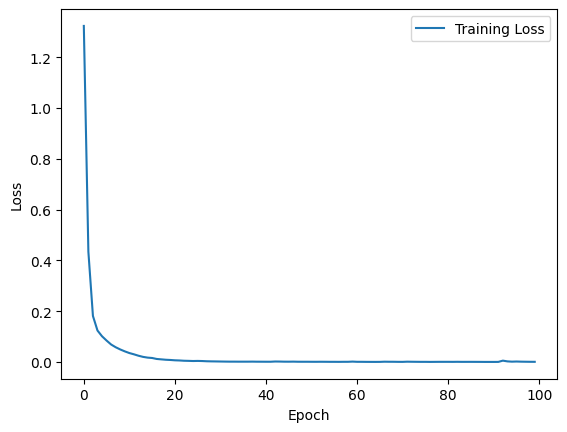

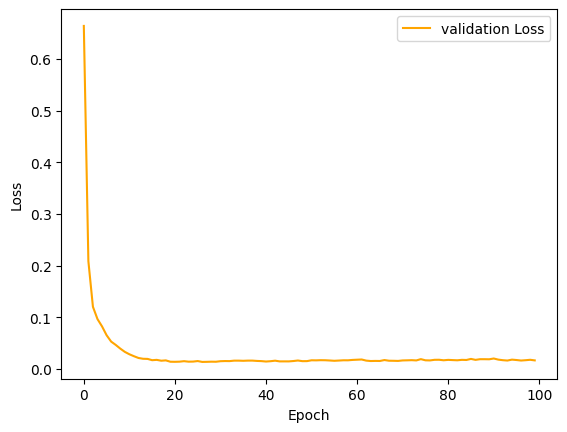

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(val_losses, label='validation Loss', color="orange")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### samples

In [ ]:
test_questions = [
    "Can you breathe?",
    "Can you ?",
    "What is the capital of the UK?",
    "Can you ask me why I'm here?",
    "Have you ever been in love?",
    "What is my purpose in life?"
]
question_answer_model_with_attention.eval()
for question in test_questions:
    question_tokens = spm.encode_as_ids(question)
    question_tensor = torch.tensor(question_tokens, dtype=torch.long)
    # print(question_tensor)
    generated_answer = question_answer_model_with_attention.answer_question(question_tensor.to(device))
    print("Question:", question)
    print("Generated Answer:", generated_answer)
    print()

Question: Can you breathe?
Generated Answer: I don's not still here if you need eat not something I's not still here if you need eat not something I's not still here if you

Question: Who wrote Romeo and Juliet?
Generated Answer: I don't any authority.

Question: What is the largest planet in our solar system?
Generated Answer: I couldn't speak to hear that.

Question: Can you ask me why I'm here?
Generated Answer: I'm better at answering questions.

Question: Have you ever been in love?
Generated Answer: Love is bey for a body Ve andt need nightyond Thanks.

Question: What is my purpose in life?
Generated Answer: I don't know.



## 6-Test evalutaion (BLEU score)
Evaluate your models on test data and calculate the [bleu score](https://machinelearningmastery.com/calculate-bleu-score-for-text-python/).

In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
# references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
# candidates = [['this', 'is', 'a', 'test']]
# score = corpus_bleu(references, candidates)
# print(score)

# references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
# candidates = [['this', 'is']]
# score = corpus_bleu(references, candidates)
# print(score)

# references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
# candidates = [['this', 'is']]
# score = corpus_bleu(references, candidates, (1, 0, 0, 0))
# print(score)

# references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
# candidates = [['this', 'is']]
# score = corpus_bleu(references, candidates, (0.5, 0.5, 0, 0))
# print(score)

In [ ]:
def test_model(model, test_dataloader, spm, device):
    model.eval()
    all_references = []
    all_candidates = []

    with torch.no_grad():
        for batch in test_dataloader:
            questions, question_lengths, answers = batch

            questions = questions.to(device)
            for i in range(len(questions)):
                question = questions[i]
                generated_answer = model.answer_question(question)
                reference = spm.decode(answers[i].tolist()).split(" ")
                candidate = spm.decode(generated_answer).split(" ")
                # blue_score = sentence_bleu(reference, candidate)
                all_references.append([reference])
                all_candidates.append(candidate)
    bleu_score = corpus_bleu(all_references, all_candidates)
    return bleu_score

bleu_score1 = test_model(question_answer_model, test_dataloader, spm, device)
bleu_score2 = test_model(question_answer_model_with_attention, test_dataloader, spm, device)
print(f"BLEU Score for simple model with no attention: {bleu_score1}")
print(f"BLEU Score for model with attention: {bleu_score2}")

BLEU Score for simple model with no attention: 0.04436395192491725
BLEU Score for model with attention: 0.31612156354479226


## 7-Samples from test set

In [34]:
with torch.no_grad():
  for batch in test_dataloader:
    questions, question_lengths, answers = batch
    questions = questions.to(device)
    for i in range(3):
      question = questions[i]
      generated_answer = question_answer_model.answer_question(question)
      generated_answer_with_attention = question_answer_model_with_attention.answer_question(question)
      question = spm.decode(question.tolist())
      reference = spm.decode(answers[i].tolist())
      generated_answer = spm.decode(generated_answer)
      generated_answer_with_attention = spm.decode(generated_answer_with_attention)
      print(f"""
      question:
      {question}
      the reference answer is:
      {reference}
      the generated answer from simple model is:
      {generated_answer}
      the generated answer from model with attention is:
      {generated_answer_with_attention}


      """)
    break


      question:
      What do you think of Google Assistant?
      the reference answer is: 
      We're all here to help.
      the generated answer from simple model is:
      I'm not really that funny.
      the generated answer from model with attention is:
      Love is beyond me.
            
            
      

      question:
      How do you feel about artificial intelligence?
      the reference answer is: 
      The world of technology is fascinating.
      the generated answer from simple model is:
      The world of technology is fascinating.
      the generated answer from model with attention is:
      Love is beyond me.
            
            
      

      question:
      Another snow day
      the reference answer is: 
      Ok.
      the generated answer from simple model is:
      I'm quite happy, thank you.
      the generated answer from model with attention is:
      I'm happy to hear that.
            
            
      
